#### Theoretical Delivered Bias Statistics in a Fundamental Factor Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import linregress
import statsmodels.api as sm

In [2]:
from factor_model_theory.code.factor_model_simulator import SimulatedMarket, Model, TrueModel, Portfolios

In order to test out the bias statistics for a theoretical fundamental factor model, we need to generate a theoretical market with a structure perfectly matching that of the axioms of a fundamental factor model. We can then run tests for the true and empirical risks of the portfolio as captured by the fundamental factor model we generate for that portfolio. 

In [3]:
# Underlying Factor Structure Characteristics
input_factor_structure = {
    'volatility': (0,6,'z-score'),
    'quality': (2,6,'z-score'),
    'size': (-2,6,'z-score'),
    'tech': (2,10, 'dummy',0.1),
    'missing_factor': (0.5, 3, 'z-score'),
    'overfit_factor': (0, 0, 'z-score')
}
stock_specific_vol = 20

# Market Structure Defaults
DEFAULT_MARKET_SIZE = 500
DEFAULT_ESTIMATION_WINDOW = 252

# Portfolio Structure Defaults
DEFAULT_PORTFOLIO_SIZE = 60
DEFAULT_PORTFOLIO_NUMBER = 200

In [4]:
market_size = DEFAULT_MARKET_SIZE
estimation_window = DEFAULT_ESTIMATION_WINDOW

port_size = DEFAULT_PORTFOLIO_SIZE
port_number = DEFAULT_PORTFOLIO_NUMBER

##### Create a universe of securities with the given factor structure

First we will generate a market of the given size, and randomly create a set of orthogonal factor exposures with the desired properties. We will then calculate factor returns for this structure, generating a series of in-sample and out-of-sample returns we can analyse.

In [5]:
# Generate simulated market for analysis
market = SimulatedMarket(input_factor_structure, stock_specific_vol)
in_sample_returns = market.in_sample_returns
out_of_sample_returns = market.out_of_sample_returns

We also generate a set of random portfolios we can analyse the risk of

In [6]:
# Generate a set of random portfolios
portfolios = Portfolios(market)

100%|██████████| 200/200 [00:00<00:00, 1882.75it/s]


##### Generate factor and idiosyncratic returns

##### Fitting Our Models

Next we will calibrate factor models, represented as objects which can then be passed back to the portfolio object, as well as creating an object reflecting the true factor model. 

The library allows us to generate models with, in this case, differing factor inclusion/exclusion. We estimate the empirical factor and idiosyncratic returns under the factor model using an equal weighted OLS. 
In this case we are investigating the effect of different levels of including and excluding factors, including spurious factors to simulate overfitting.


In [7]:
# Estimate empirical factor returns from the security returns

# Calibrate underfit model
small_model = Model(market, 'underfit_model')
small_model._fit_returns(['overfit', 'missing'])

# Calibrate overfit model
full_model = Model(market, 'overfit_model')
full_model._fit_returns()

# Generate theoretical covariance matrix and idiosyncratic vols
true_model = TrueModel(market)

# Create model list for iteration 
model_list = [small_model, full_model, true_model]

This allows us to compare factor and idiosyncratic volatilities, as well as the distribution of daily r-squared values and their average. 

Percentage increase in average model R-squared is 9.68%


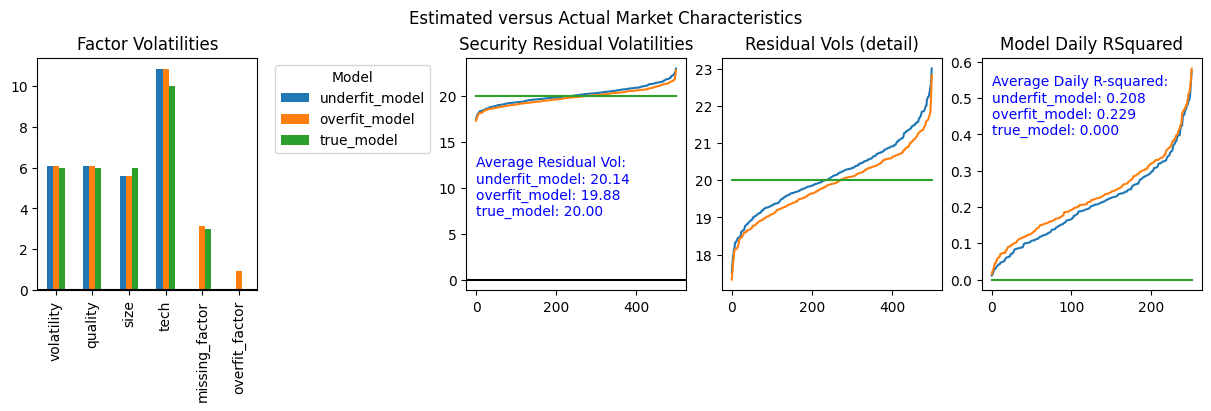

In [8]:
# Generate a vector of theoretical vs true factor vols
factor_vols = pd.DataFrame({model.model_name:model.factor_vols for model in model_list})

# Compare the distribution of idiosyncratic vols
idio_vols = pd.DataFrame({model.model_name: model.idio_vols.sort_values().reset_index(drop=True) 
                          for model in model_list})

# Generate series of RSquared values
rsq = pd.DataFrame({model.model_name: 
                        model.rsq.sort_values().reset_index(drop=True) if type(model.rsq) == pd.Series 
                        else model.rsq
                    for model in model_list})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,4), constrained_layout=True)
fig.suptitle('Estimated versus Actual Market Characteristics')
factor_vols.plot.bar(ax=ax1, title='Factor Volatilities')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')
ax1.axhline(0, color='k')
idio_vols.plot.line(ax=ax2, title='Security Residual Volatilities', legend=False)
ax2.axhline(0, color='k')
idio_vols.plot.line(ax=ax3, title='Residual Vols (detail)', legend=False)
ax2_text = f'Average Residual Vol:\n' + '\n'.join([f'{model.model_name}: {model.idio_vols.mean():.2f}' for model in model_list])
ax2.text(x=0.5, y=7, s=ax2_text, color='b')
rsq.sort_values('underfit_model').reset_index(drop=True).plot(ax=ax4, title='Model Daily RSquared', legend=False)
ax4_text = f'Average Daily R-squared:\n' + '\n'.join([f'{model.model_name}: {pd.Series(model.rsq).mean():.3f}' for model in model_list])
ax4.text(x=0.5, y=0.4, s=ax4_text, color='b')
plt.savefig('risk_model_parameter_comparison.png')

print(f'Percentage increase in average model R-squared is {((rsq.overfit_model.mean() / rsq.underfit_model.mean()) - 1) * 100:.2f}%')

#### Create Portfolios for Risk Estimate Testing 
 
Generate a set of random equal-weight portfolios which we can then estimate theoretical and empirical risk statistics for

In [9]:
# Calculate the factor exposure vector for each portfolio
port_exposures = portfolios.exposures

# Calculate ex-post returns and delivered for each portfolio
port_in_sample_returns = portfolios.weights.transpose().dot(in_sample_returns)
port_in_sample_ex_post_vol = pd.Series(port_in_sample_returns.std(axis=1) * (252 ** 0.5), name='in_sample_ex_post_vol')

port_out_sample_returns = portfolios.weights.transpose().dot(out_of_sample_returns)
port_out_sample_ex_post_vol = pd.Series(port_out_sample_returns.std(axis=1) * (252 ** 0.5), name='out_sample_ex_post_vol')

#### Generate Risk Estimates

For each model, we generate portfolio risk estimates. We can also generate ex post volatility data for the portfolios. This allows us to compare the risk estimates for each model against the true underlying model. 

In [10]:
# Generate CAR breakdown for each model
true_model_port_car = portfolios.model_car(true_model)
small_model_port_car = portfolios.model_car(small_model)
full_model_port_car = portfolios.model_car(full_model)

In [11]:
# Generate CAR breakdown for each model
true_model_port_risk = portfolios.model_risk(true_model)
small_model_port_risk = portfolios.model_risk(small_model)
full_model_port_risk = portfolios.model_risk(full_model)

#### Compare Risk Estimates

<Axes: >

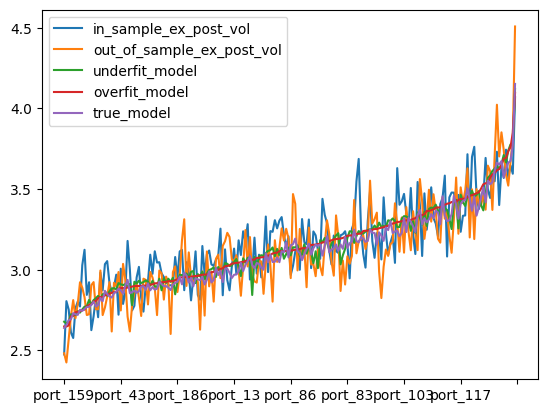

In [12]:
# Generate model car comparison
port_car_comparison = pd.DataFrame([portfolios.ex_post_vol('in_sample'), portfolios.ex_post_vol('out_of_sample')]).transpose()
for model in model_list:
    port_car_comparison[model.model_name] = portfolios.model_risk(model)

port_car_comparison.sort_values('overfit_model').plot()

In [19]:
def deviation_from_true_structure(portfolios, model, true_model=None):
    if type(model) == str:
        return (portfolios.ex_post_vol('out_of_sample') / portfolios.model_risk(true_model) - 1).sort_values()
    else:
        return (portfolios.model_risk(model) / portfolios.model_risk(true_model) - 1).sort_values()

In [22]:
def ex_post_model_bias(portfolios, model, returns_type='out_of_sample'):
    if type(model) == str:
        return (portfolios.ex_post_vol(returns_type) / portfolios.ex_post_vol(model) - 1).sort_values()
    else:
        return (portfolios.ex_post_vol(returns_type) / portfolios.model_risk(model) - 1).sort_values()

#### Ex-Post and Ex-Ante Risk versus Risk MOdel Estimates

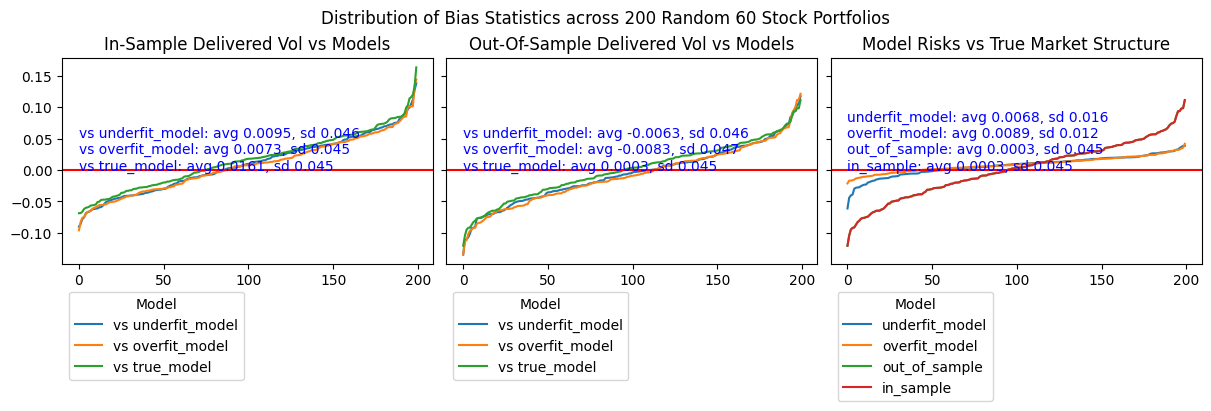

In [37]:
# Generate summary bias statistics
in_sample_bias = pd.DataFrame([ex_post_model_bias(portfolios, model, 'in_sample').reset_index(drop=True).rename(f'vs {model.model_name}') 
                               for model in model_list]).transpose()
out_sample_bias = pd.DataFrame([ex_post_model_bias(portfolios, model, 'out_of_sample').reset_index(drop=True).rename(f'vs {model.model_name}')
                                for model in model_list]).transpose()

# Get contributions to bias for full model
model_deviation = pd.DataFrame([deviation_from_true_structure(portfolios, model, true_model).reset_index(drop=True).rename(f'{model.model_name}') if type(model) != str
                                else deviation_from_true_structure(portfolios, model, true_model).reset_index(drop=True).rename(f'{model}')
                                for model in [x for x in model_list if x.model_name != 'true_model'] + ['out_of_sample', 'in_sample']]
                               ).transpose()

# Generate comparison
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle(f'Distribution of Bias Statistics across {port_number} Random {port_size} Stock Portfolios')

# Plot data for tests of the model against the out-of-sample volatilities
in_sample_bias.plot(ax=ax1, title='In-Sample Delivered Vol vs Models')
ax1.legend(bbox_to_anchor=(0.0, -0.1), loc='upper left', title='Model')
ax1_text = '\n'.join([f'{col}: avg {in_sample_bias[col].mean():.4f}, sd {in_sample_bias[col].std():.3f}' for col in in_sample_bias.columns])
ax1.text(x=0, y=0, s=ax1_text, color='b')
ax1.axhline(0, color='r')

# Plot data for tests of the model against the in-sample volatilities
out_sample_bias.plot(ax=ax2, title='Out-Of-Sample Delivered Vol vs Models')
ax2.legend(bbox_to_anchor=(0.0, -0.1), loc='upper left', title='Model')
ax2_text = '\n'.join([f'{col}: avg {out_sample_bias[col].mean():.4f}, sd {out_sample_bias[col].std():.3f}' for col in out_sample_bias.columns])
ax2.text(x=0, y=0, s=ax2_text, color='b')
ax2.axhline(0, color='r')

# Plot data for tests of the models and delivered outcomes against the true model structure
model_deviation.plot(ax=ax3, title='Model Risks vs True Market Structure')
ax3.legend(bbox_to_anchor=(0.0, -0.1), loc='upper left', title='Model')
ax3_text = '\n'.join([f'{col}: avg {model_deviation[col].mean():.4f}, sd {model_deviation[col].std():.3f}' for col in model_deviation.columns])
ax3.text(x=0, y=0, s=ax3_text, color='b')
ax3.axhline(0, color='r')

plt.savefig('bias_vs_ex_post_and_true.png')

#### Simulated Model Performance

In [42]:
# Underlying Factor Structure Characteristics
input_factor_structure = {
    '15pct_zsc': (0,15,'z-score'),
    '10pct_zsc': (0,10,'z-score'),
    '08pct_zsc': (0, 8,'z-score'),
    '05pct_zsc': (0, 5,'z-score'),
    '03pct_zsc': (0, 3,'z-score'),
    '02pct_zsc': (0, 2,'z-score'),
    '01pct_zsc': (0, 1,'z-score'),
    '.5pct_zsc': (0,.5,'z-score'),
    
    '10pct_ind': (0,10, 'dummy',0.1),
    '05pct_ind': (0, 5, 'dummy',0.1),
    '02pct_ind': (0, 2, 'dummy',0.1),
    '01pct_ind': (0, 1, 'dummy',0.1),
    
    'missing_1': (0,10, 'z-score'),
    'missing_2': (0, 5, 'z-score'),
    'missing_3': (0, 3, 'z-score'),
    'missing_4': (0, 2, 'z-score'),
    'missing_5': (0, 1, 'z-score'),
    
    'overfit_zsc_1': (0, 0, 'z-score'),
    'overfit_zsc_2': (0, 0, 'z-score'),
    'overfit_zsc_3': (0, 0, 'z-score'),
    'overfit_zsc_4': (0, 0, 'z-score'),
    'overfit_zsc_5': (0, 0, 'z-score')
}

stock_specific_vol = 20

In [70]:
sim_avg_rsq = {}
sim_factor_vols = {}
sim_tstats = {}

for sim in tqdm(range(100)):
    # Simulate market
    market = SimulatedMarket(input_factor_structure, stock_specific_vol)
    
    # Estimate model and collect statistics 
    model = Model(market, 'full_model')
    model._fit_returns()
    sim_avg_rsq[sim] = model.rsq.mean()
    sim_factor_vols[sim] = model.factor_vols
    sim_tstats[sim] = model.tstat
    
factor_vol_sim = pd.DataFrame(sim_factor_vols)

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


<Axes: xlabel='mean_vol', ylabel='std_of_vol'>

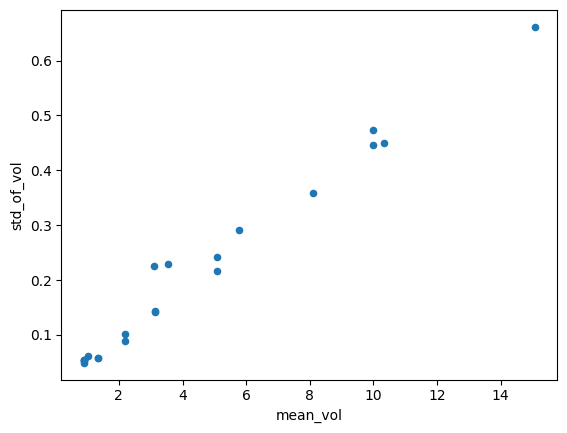

In [71]:
factor_vol_dist = factor_vol_sim.mean(axis=1).rename('mean_vol').to_frame().join(factor_vol_sim.std(axis=1).rename('std_of_vol'))
factor_vol_dist.plot.scatter(x='mean_vol', y='std_of_vol')

In [64]:
sim_tstats[0].shape[1]

252

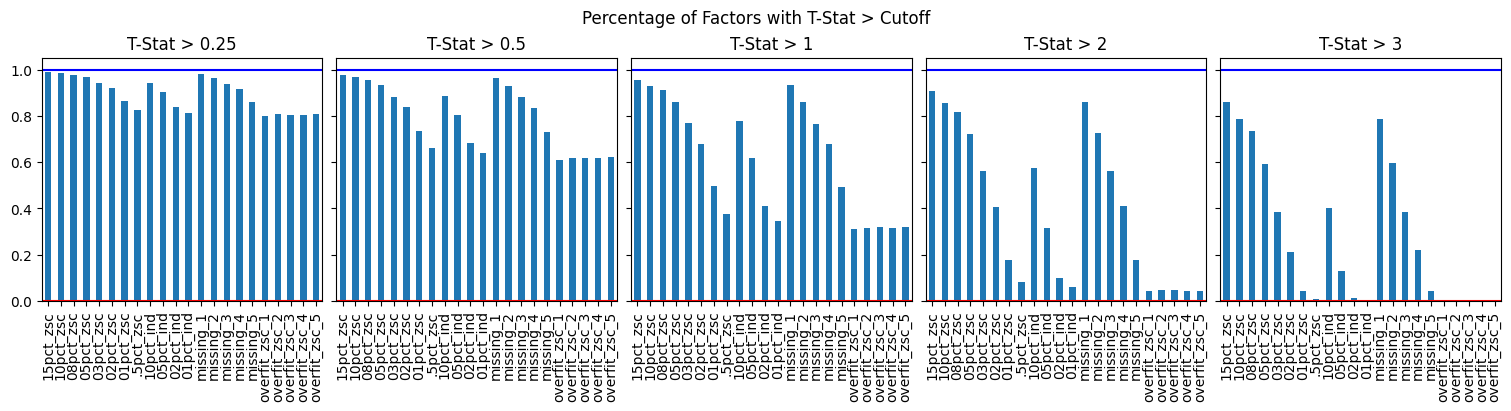

In [79]:
cutoffs = [0.25, 0.5, 1, 2, 3]

sim_tstat_cutoffs = {}
for cutoff in cutoffs:
    sim_tstat_cutoffs[cutoff] = {}
    for sim_no, sim_tstat_dist in sim_tstats.items():
        sim_tstat_cutoffs[cutoff][sim_no] = np.sum(np.abs(sim_tstat_dist)>cutoff, axis=1) / sim_tstat_dist.shape[1]



fig, ax = plt.subplots(1,len(cutoffs), figsize=(15,4), constrained_layout=True, sharex=True, sharey=True)
i = 0
fig.suptitle('Percentage of Factors with T-Stat > Cutoff')
for cutoff in cutoffs:
    pd.DataFrame(sim_tstat_cutoffs[cutoff]).mean(axis=1).plot.bar(ax=ax[i], title=f'T-Stat > {cutoff}')
    ax[i].axhline(0, color='r')
    ax[i].axhline(1, color='b')
    i=i+1
    

In [80]:
np.std(sim_tstat_dist, axis=1) 

15pct_zsc        17.789434
10pct_zsc        11.762156
08pct_zsc         8.500477
05pct_zsc         5.255346
03pct_zsc         3.314909
02pct_zsc         2.215752
01pct_zsc         1.460412
.5pct_zsc         1.117221
10pct_ind         3.459378
05pct_ind         1.922488
02pct_ind         1.181380
01pct_ind         1.039180
missing_1        11.721426
missing_2         5.576266
missing_3         3.649479
missing_4         2.397189
missing_5         1.480844
overfit_zsc_1     0.956210
overfit_zsc_2     0.950478
overfit_zsc_3     0.954571
overfit_zsc_4     1.006902
overfit_zsc_5     0.998645
dtype: float64

In [82]:
from statsmodels.multivariate.pca import PCA

In [104]:
pc = PCA(market.out_of_sample_returns, ncomp=30)

<Axes: >

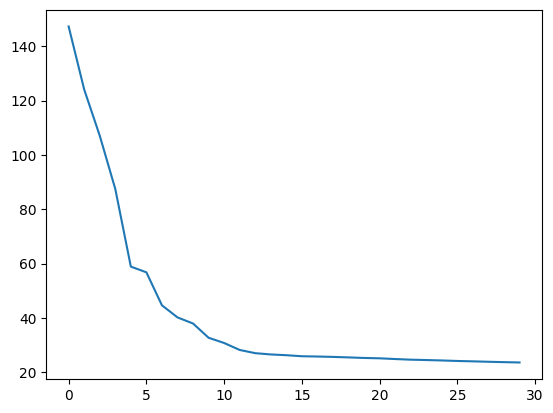

In [105]:
(pc.eigenvals ** 0.5).plot()

In [107]:
vector = sm.OLS(pc.factors.iloc[:,2], market.exposures)
res = vector.fit()
res.params

15pct_zsc       -0.007001
10pct_zsc       -0.041279
08pct_zsc        0.011326
05pct_zsc        0.001731
03pct_zsc       -0.000055
02pct_zsc        0.000191
01pct_zsc       -0.000499
.5pct_zsc        0.000174
10pct_ind       -0.002042
05pct_ind       -0.000369
02pct_ind       -0.001923
01pct_ind       -0.000038
missing_1       -0.019152
missing_2        0.002271
missing_3        0.001012
missing_4       -0.000134
missing_5        0.000396
overfit_zsc_1    0.000151
overfit_zsc_2    0.000365
overfit_zsc_3   -0.000004
overfit_zsc_4    0.000045
overfit_zsc_5   -0.000177
dtype: float64

Text(0, 0.5, '% Chance of 1 False Positive')

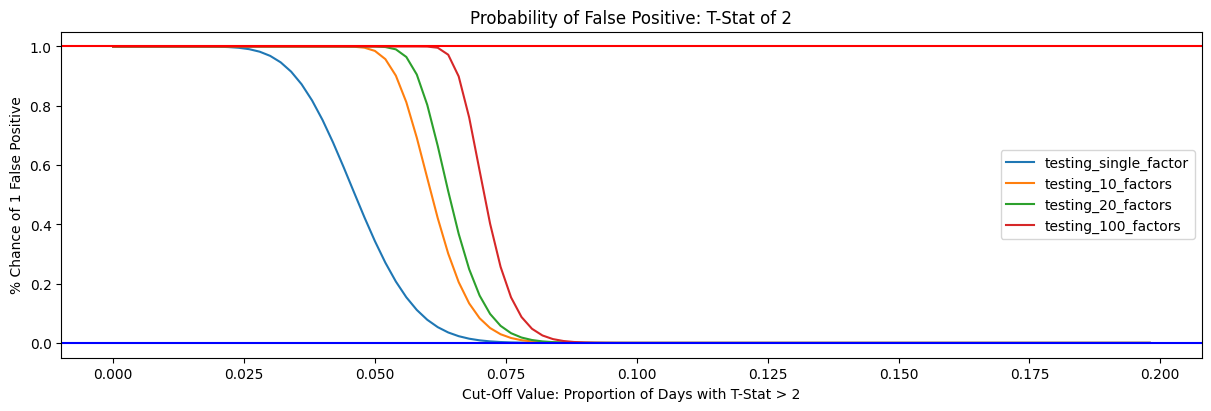

In [147]:
# Probability of false positive

from scipy.stats import binom

single_test = {}
multiple_test_10 = {}
multiple_test_20 = {}
multiple_test_100 = {}
steps=500
no_datapoints = 500
prob = 0.9545

for i in range(int(steps*0.2)):
    single_test[i/steps] = binom.cdf(int(no_datapoints - i*no_datapoints/steps), no_datapoints, prob)
    multiple_test_10[i/steps] = 1 - binom.pmf(0, 10, single_test[i/steps])
    multiple_test_20[i/steps] = 1 - binom.cdf(0, 20, single_test[i/steps])
    multiple_test_100[i/steps] = 1 - binom.cdf(0, 100, single_test[i/steps])
fig, ax1 = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
results = pd.DataFrame({'testing_single_factor':single_test,
                        'testing_10_factors':multiple_test_10,
                        'testing_20_factors':multiple_test_20,
                        'testing_100_factors':multiple_test_100}).plot(title='Probability of False Positive: T-Stat of 2', ax=ax1)
# Set horizontal title for ax1
ax1.axhline(1, color='r')
ax1.axhline(0, color='b')
ax1.set_xlabel('Cut-Off Value: Proportion of Days with T-Stat > 2')
ax1.set_ylabel('% Chance of 1 False Positive')

In [ ]:
from scipy.stats import norm

norm.cdf()

In [ ]:
# Probability of false positive

from scipy.stats import binom

single_test = {}
multiple_test_10 = {}
multiple_test_20 = {}
multiple_test_100 = {}
steps=500
no_datapoints = 500
prob = 0.9545

for i in range(int(steps*0.2)):
    single_test[i/steps] = binom.cdf(int(no_datapoints - i*no_datapoints/steps), no_datapoints, prob)
    multiple_test_10[i/steps] = 1 - binom.pmf(0, 10, single_test[i/steps])
    multiple_test_20[i/steps] = 1 - binom.cdf(0, 20, single_test[i/steps])
    multiple_test_100[i/steps] = 1 - binom.cdf(0, 100, single_test[i/steps])
fig, ax1 = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
results = pd.DataFrame({'testing_single_factor':single_test,
                        'testing_10_factors':multiple_test_10,
                        'testing_20_factors':multiple_test_20,
                        'testing_100_factors':multiple_test_100}).plot(title='Probability of False Positive: T-Stat of 2', ax=ax1)
# Set horizontal title for ax1
ax1.axhline(1, color='r')
ax1.axhline(0, color='b')
ax1.set_xlabel('Cut-Off Value: Proportion of Days with T-Stat > 2')
ax1.set_ylabel('% Chance of 1 False Positive')

In [122]:
prob = 0.9545


np.float64(4.85400697853229e-06)

<Axes: >

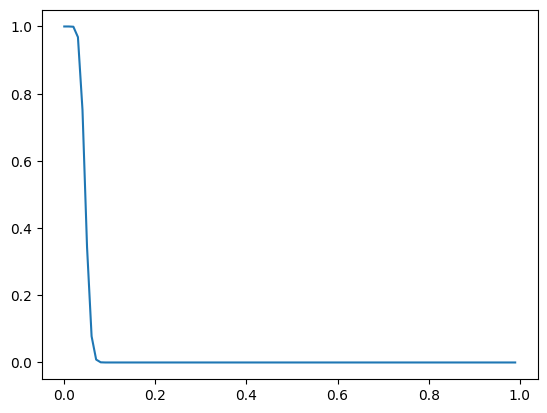

In [111]:
market.exposures.transpose().dot(market.exposures)

,15pct_zsc,10pct_zsc,08pct_zsc,05pct_zsc,03pct_zsc,02pct_zsc,01pct_zsc,.5pct_zsc,10pct_ind,05pct_ind,...,missing_1,missing_2,missing_3,missing_4,missing_5,overfit_zsc_1,overfit_zsc_2,overfit_zsc_3,overfit_zsc_4,overfit_zsc_5
15pct_zsc,490.749267,-47.084497,-45.864345,-8.846967,11.144543,28.306361,27.904695,-40.412514,-9.500790,-14.849770,...,23.046665,-5.785113,-9.666336,31.848595,-9.428070,21.625946,18.398852,34.243544,20.544116,-4.876906
10pct_zsc,-47.084497,465.542345,12.365333,4.275024,25.634490,-57.867252,19.274897,-2.349264,5.772887,5.728465,...,-52.607540,6.551945,3.523679,-10.451689,-2.981213,-10.558460,7.322398,-16.553204,2.028283,-40.389096
08pct_zsc,-45.864345,12.365333,489.588942,40.510139,-7.289800,-34.818450,-7.378385,7.791560,2.055408,-7.019729,...,8.843108,-13.868220,-23.562285,26.195366,4.524027,6.089971,-37.094774,-31.401757,-16.691837,-8.618132
05pct_zsc,-8.846967,4.275024,40.510139,472.865387,-23.873901,-21.725010,25.502463,-13.698609,-4.194478,-0.898149,...,22.408443,43.197865,-2.041674,-3.092190,8.522256,5.387115,-16.979335,18.768939,-7.210788,15.547533
03pct_zsc,11.144543,25.634490,-7.289800,-23.873901,480.568607,15.486777,-10.074153,11.433863,-4.625177,-7.191245,...,13.185587,17.019771,-18.055166,16.664124,-21.766650,-13.840265,24.324689,-1.218049,3.643668,14.211045
02pct_zsc,28.306361,-57.867252,-34.818450,-21.725010,15.486777,442.313119,-18.672515,-32.126897,-12.057088,11.952151,...,-1.255034,-11.480078,28.643355,-13.997563,-6.306433,3.128771,33.997807,-3.410879,21.341108,12.055311
01pct_zsc,27.904695,19.274897,-7.378385,25.502463,-10.074153,-18.672515,505.057275,-31.136040,-7.073505,-5.523189,...,-5.713285,8.455408,-11.531294,-5.048011,-8.687414,-1.428382,27.913306,25.830114,15.326637,-26.592099
.5pct_zsc,-40.412514,-2.349264,7.791560,-13.698609,11.433863,-32.126897,-31.136040,492.932032,6.854660,5.017855,...,-5.692422,6.970127,18.865435,-26.812593,24.403582,-35.812892,-11.294166,4.430120,-6.638794,-21.106783
10pct_ind,-9.500790,5.772887,2.055408,-4.194478,-4.625177,-12.057088,-7.073505,6.854660,53.000000,4.000000,...,13.901903,13.753586,1.245158,9.338007,5.254615,0.775137,0.659008,1.544829,-4.194411,-2.166578
05pct_ind,-14.849770,5.728465,-7.019729,-0.898149,-7.191245,11.952151,-5.523189,5.017855,4.000000,56.000000,...,-9.000323,15.362510,6.246142,-1.371736,5.482619,-4.108377,2.514277,7.199733,5.019247,-1.724776
